# CSIRO Biomass Prediction - EDA
**Objective**: Predict 5 biomass components from pasture images
- Dry_Green_g, Dry_Dead_g, Dry_Clover_g, GDM_g, Dry_Total_g

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

DATA_DIR = Path(r'E:\csiro-biomass')
df = pd.read_csv(DATA_DIR / 'train.csv')
print(f"Shape: {df.shape}")
df.head(10)

Shape: (1785, 9)


sample_id              image_path Sampling_Date State  \
0  ID1011485656__Dry_Clover_g  train/ID1011485656.jpg      2015/9/4   Tas   
1    ID1011485656__Dry_Dead_g  train/ID1011485656.jpg      2015/9/4   Tas   
2   ID1011485656__Dry_Green_g  train/ID1011485656.jpg      2015/9/4   Tas   
3   ID1011485656__Dry_Total_g  train/ID1011485656.jpg      2015/9/4   Tas   
4         ID1011485656__GDM_g  train/ID1011485656.jpg      2015/9/4   Tas   
5  ID1012260530__Dry_Clover_g  train/ID1012260530.jpg      2015/4/1   NSW   
6    ID1012260530__Dry_Dead_g  train/ID1012260530.jpg      2015/4/1   NSW   
7   ID1012260530__Dry_Green_g  train/ID1012260530.jpg      2015/4/1   NSW   
8   ID1012260530__Dry_Total_g  train/ID1012260530.jpg      2015/4/1   NSW   
9         ID1012260530__GDM_g  train/ID1012260530.jpg      2015/4/1   NSW   

           Species  Pre_GSHH_NDVI  Height_Ave_cm   target_name   target  
0  Ryegrass_Clover           0.62         4.6667  Dry_Clover_g   0.0000  
1  Ryegrass_Clover           0.62         4.6667    Dry_Dead_g  31.9984  
2  Ryegrass_Clover           0.62         4.6667   Dry_Green_g  16.2751  
3  Ryegrass_Clover           0.62         4.6667   Dry_Total_g  48.2735  
4  Ryegrass_Clover           0.62         4.6667         GDM_g  16.2750  
5          Lucerne           0.55        16.0000  Dry_Clover_g   0.0000  
6          Lucerne           0.55        16.0000    Dry_Dead_g   0.0000  
7          Lucerne           0.55        16.0000   Dry_Green_g   7.6000  
8          Lucerne           0.55        16.0000   Dry_Total_g   7.6000  
9          Lucerne           0.55        16.0000         GDM_g   7.6000

## 1. Data Overview

In [2]:
# Unique images vs rows (5 targets per image)
n_images = df['image_path'].nunique()
print(f"Unique images: {n_images}")
print(f"Rows per image: {len(df) // n_images}")
print(f"\nTarget classes: {df['target_name'].unique()}")
print(f"\nStates: {df['State'].unique()}")
print(f"\nSpecies count: {df['Species'].nunique()}")
print(f"\nDate range: {df['Sampling_Date'].min()} to {df['Sampling_Date'].max()}")

Unique images: 357
Rows per image: 5

Target classes: ['Dry_Clover_g' 'Dry_Dead_g' 'Dry_Green_g' 'Dry_Total_g' 'GDM_g']

States: ['Tas' 'NSW' 'WA' 'Vic']

Species count: 15

Date range: 2015/1/15 to 2015/9/4


In [3]:
# Missing values
print("Missing values:")
print(df.isnull().sum())
print(f"\nNDVI missing: {df['Pre_GSHH_NDVI'].isna().sum()} ({100*df['Pre_GSHH_NDVI'].isna().mean():.1f}%)")
print(f"Height missing: {df['Height_Ave_cm'].isna().sum()} ({100*df['Height_Ave_cm'].isna().mean():.1f}%)")

Missing values:
sample_id        0
image_path       0
Sampling_Date    0
State            0
Species          0
Pre_GSHH_NDVI    0
Height_Ave_cm    0
target_name      0
target           0
dtype: int64

NDVI missing: 0 (0.0%)
Height missing: 0 (0.0%)


## 2. Target Distribution Analysis

In [4]:
# Pivot to wide format for correlation analysis
df_wide = df.pivot_table(index='image_path', columns='target_name', values='target', aggfunc='first').reset_index()
df_meta = df.drop_duplicates('image_path')[['image_path', 'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm']]
df_wide = df_wide.merge(df_meta, on='image_path')
print(f"Wide format shape: {df_wide.shape}")
df_wide.head()

Wide format shape: (357, 11)


image_path  Dry_Clover_g  Dry_Dead_g  Dry_Green_g  Dry_Total_g  \
0  train/ID1011485656.jpg        0.0000     31.9984      16.2751      48.2735   
1  train/ID1012260530.jpg        0.0000      0.0000       7.6000       7.6000   
2  train/ID1025234388.jpg        6.0500      0.0000       0.0000       6.0500   
3  train/ID1028611175.jpg        0.0000     30.9703      24.2376      55.2079   
4  train/ID1035947949.jpg        0.4343     23.2239      10.5261      34.1844   

     GDM_g Sampling_Date State            Species  Pre_GSHH_NDVI  \
0  16.2750      2015/9/4   Tas    Ryegrass_Clover           0.62   
1   7.6000      2015/4/1   NSW            Lucerne           0.55   
2   6.0500      2015/9/1    WA  SubcloverDalkeith           0.38   
3  24.2376     2015/5/18   Tas           Ryegrass           0.66   
4  10.9605     2015/9/11   Tas           Ryegrass           0.54   

   Height_Ave_cm  
0         4.6667  
1        16.0000  
2         1.0000  
3         5.0000  
4         3.5000

In [5]:
# Target statistics per class
targets = ['Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'Dry_Total_g']
stats = df_wide[targets].describe().T
stats['zeros'] = (df_wide[targets] == 0).sum()
stats['zeros_pct'] = 100 * stats['zeros'] / len(df_wide)
stats

count       mean        std   min      25%      50%      75%  \
Dry_Green_g   357.0  26.624722  25.401232  0.00   8.8000  20.8000  35.0834   
Dry_Dead_g    357.0  12.044548  12.402007  0.00   3.2000   7.9809  17.6378   
Dry_Clover_g  357.0   6.649692  12.117761  0.00   0.0000   1.4235   7.2429   
GDM_g         357.0  33.274414  24.935822  1.04  16.0261  27.1082  43.6757   
Dry_Total_g   357.0  45.318097  27.984015  1.04  25.2715  40.3000  57.8800   

                   max  zeros  zeros_pct  
Dry_Green_g   157.9836     18   5.042017  
Dry_Dead_g     83.8407     40  11.204482  
Dry_Clover_g   71.7865    135  37.815126  
GDM_g         157.9836      0   0.000000  
Dry_Total_g   185.7000      0   0.000000

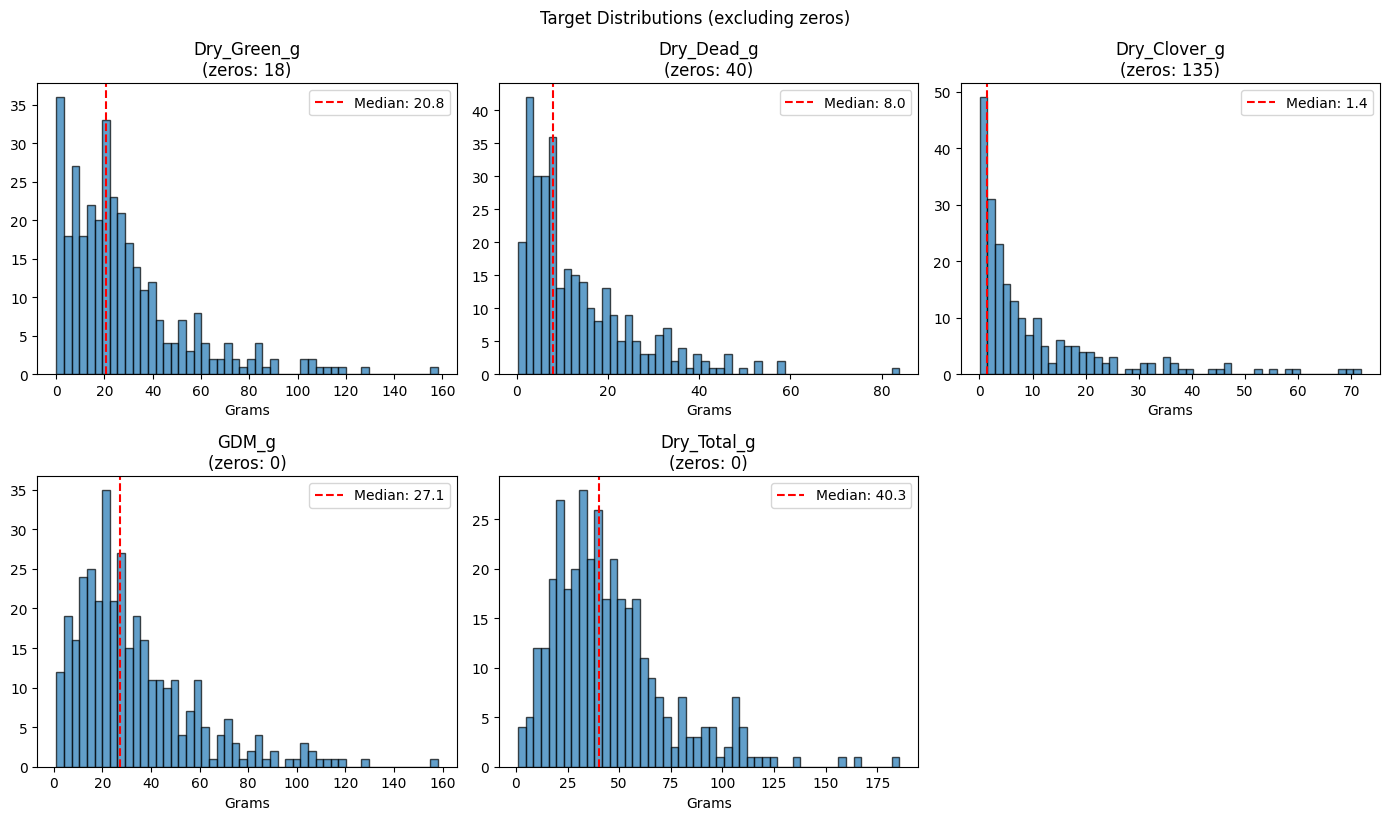

In [6]:
# Target distributions
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, target in enumerate(targets):
    ax = axes[i]
    data = df_wide[target]
    ax.hist(data[data > 0], bins=50, edgecolor='black', alpha=0.7)
    ax.axvline(data.median(), color='red', linestyle='--', label=f'Median: {data.median():.1f}')
    ax.set_title(f'{target}\n(zeros: {(data==0).sum()})')
    ax.set_xlabel('Grams')
    ax.legend()

axes[-1].axis('off')
plt.tight_layout()
plt.suptitle('Target Distributions (excluding zeros)', y=1.02)
plt.show()

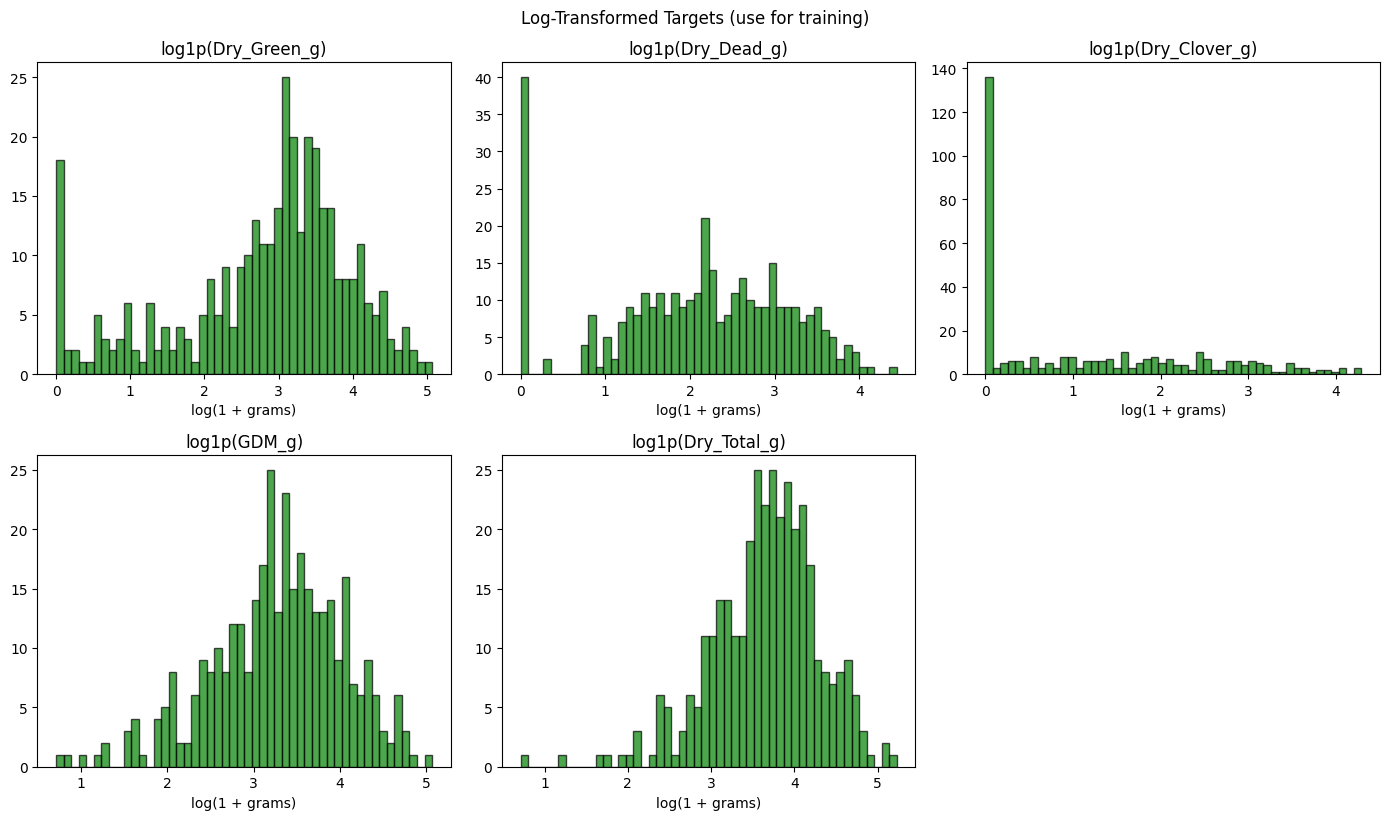

In [7]:
# Log-transformed distributions (better for regression)
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, target in enumerate(targets):
    ax = axes[i]
    data = df_wide[target]
    log_data = np.log1p(data)  # log(1+x) to handle zeros
    ax.hist(log_data, bins=50, edgecolor='black', alpha=0.7, color='green')
    ax.set_title(f'log1p({target})')
    ax.set_xlabel('log(1 + grams)')

axes[-1].axis('off')
plt.tight_layout()
plt.suptitle('Log-Transformed Targets (use for training)', y=1.02)
plt.show()

## 3. Target Correlations & Relationships

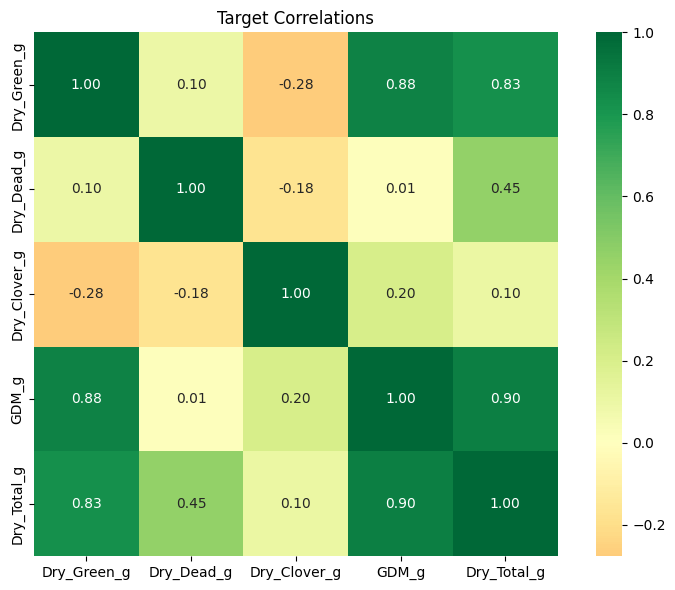

Key insights:
- Dry_Total_g = Dry_Green_g + Dry_Dead_g + Dry_Clover_g (compositional)
- GDM_g = Dry_Green_g + Dry_Clover_g (green dry matter)


In [8]:
# Correlation between targets
corr = df_wide[targets].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='RdYlGn', center=0, fmt='.2f', square=True)
plt.title('Target Correlations')
plt.tight_layout()
plt.show()

print("Key insights:")
print("- Dry_Total_g = Dry_Green_g + Dry_Dead_g + Dry_Clover_g (compositional)")
print("- GDM_g = Dry_Green_g + Dry_Clover_g (green dry matter)")

In [9]:
# Verify compositional relationships
df_wide['check_total'] = df_wide['Dry_Green_g'] + df_wide['Dry_Dead_g'] + df_wide['Dry_Clover_g']
df_wide['check_gdm'] = df_wide['Dry_Green_g'] + df_wide['Dry_Clover_g']

print(f"Dry_Total matches sum: {np.allclose(df_wide['Dry_Total_g'], df_wide['check_total'], atol=0.1)}")
print(f"GDM matches sum: {np.allclose(df_wide['GDM_g'], df_wide['check_gdm'], atol=0.1)}")

# Show discrepancies if any
diff_total = np.abs(df_wide['Dry_Total_g'] - df_wide['check_total'])
diff_gdm = np.abs(df_wide['GDM_g'] - df_wide['check_gdm'])
print(f"\nMax discrepancy Total: {diff_total.max():.4f}")
print(f"Max discrepancy GDM: {diff_gdm.max():.4f}")

Dry_Total matches sum: False
GDM matches sum: True

Max discrepancy Total: 0.3088
Max discrepancy GDM: 0.0001


## 4. NDVI & Height Correlations with Targets

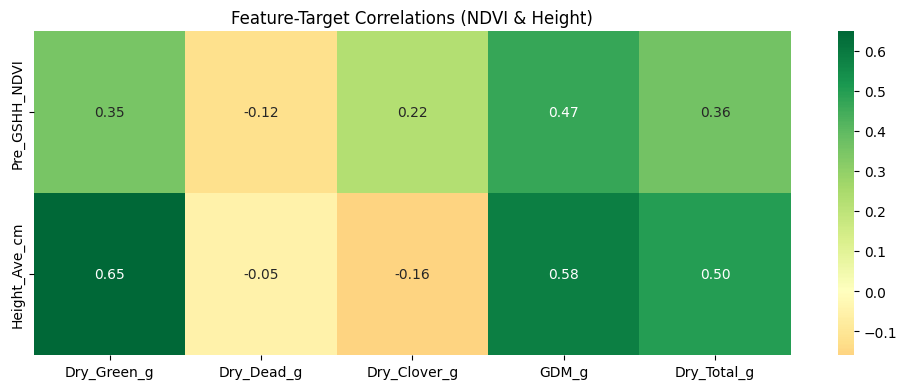

In [10]:
# Correlation of features with targets
features = ['Pre_GSHH_NDVI', 'Height_Ave_cm']
corr_feat = df_wide[features + targets].corr().loc[features, targets]

plt.figure(figsize=(10, 4))
sns.heatmap(corr_feat, annot=True, cmap='RdYlGn', center=0, fmt='.2f')
plt.title('Feature-Target Correlations (NDVI & Height)')
plt.tight_layout()
plt.show()

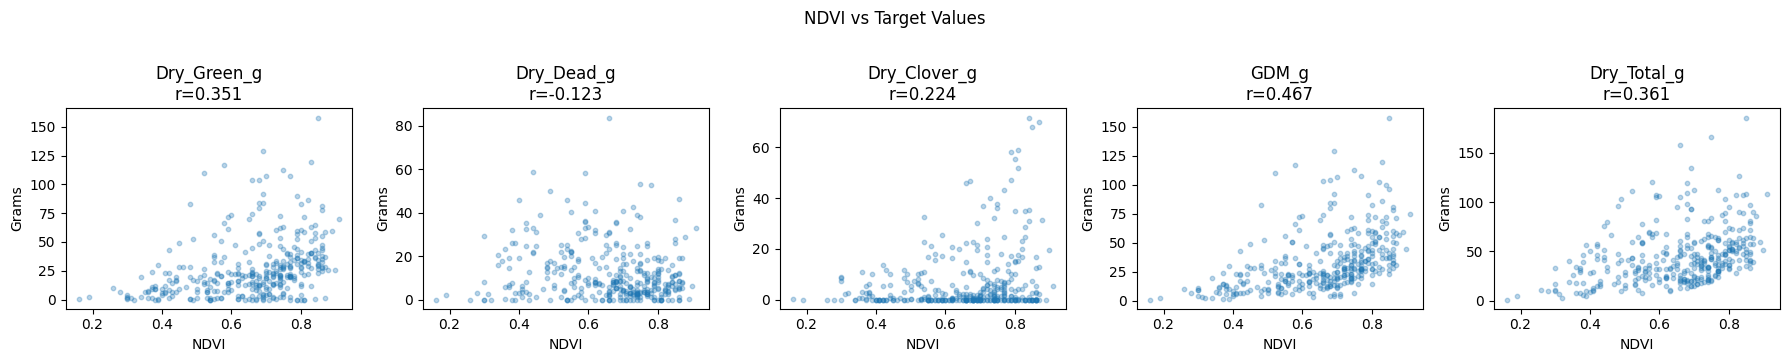

In [11]:
# Scatter plots: NDVI vs targets
fig, axes = plt.subplots(1, 5, figsize=(18, 3.5))
for i, target in enumerate(targets):
    ax = axes[i]
    mask = ~df_wide['Pre_GSHH_NDVI'].isna()
    ax.scatter(df_wide.loc[mask, 'Pre_GSHH_NDVI'], df_wide.loc[mask, target], alpha=0.3, s=10)
    r = df_wide.loc[mask, ['Pre_GSHH_NDVI', target]].corr().iloc[0, 1]
    ax.set_title(f'{target}\nr={r:.3f}')
    ax.set_xlabel('NDVI')
    ax.set_ylabel('Grams')
plt.suptitle('NDVI vs Target Values', y=1.02)
plt.tight_layout()
plt.show()

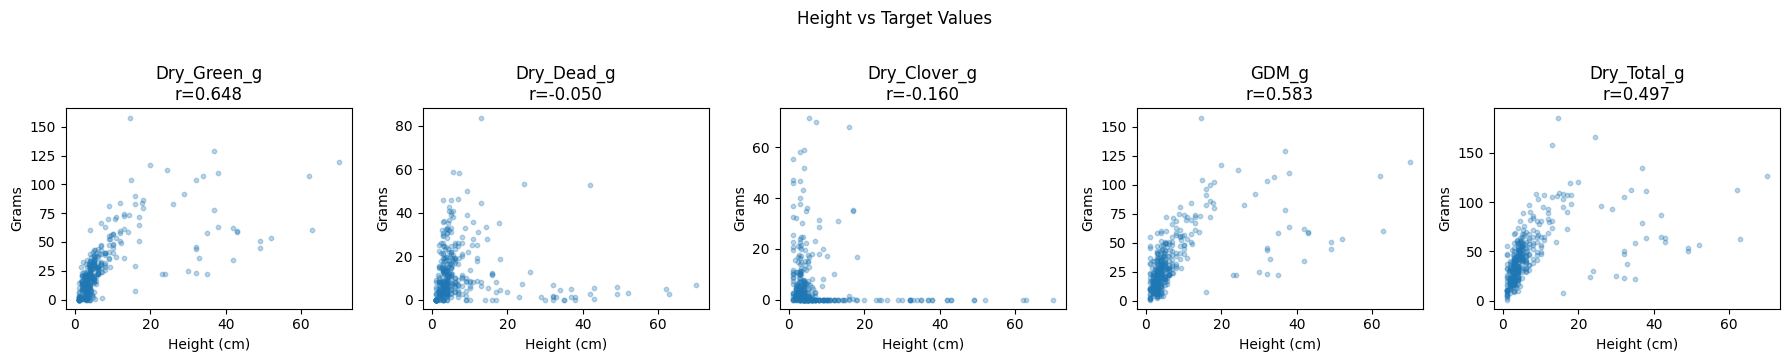

In [12]:
# Scatter plots: Height vs targets
fig, axes = plt.subplots(1, 5, figsize=(18, 3.5))
for i, target in enumerate(targets):
    ax = axes[i]
    mask = ~df_wide['Height_Ave_cm'].isna()
    ax.scatter(df_wide.loc[mask, 'Height_Ave_cm'], df_wide.loc[mask, target], alpha=0.3, s=10)
    r = df_wide.loc[mask, ['Height_Ave_cm', target]].corr().iloc[0, 1]
    ax.set_title(f'{target}\nr={r:.3f}')
    ax.set_xlabel('Height (cm)')
    ax.set_ylabel('Grams')
plt.suptitle('Height vs Target Values', y=1.02)
plt.tight_layout()
plt.show()

## 5. Categorical Feature Analysis

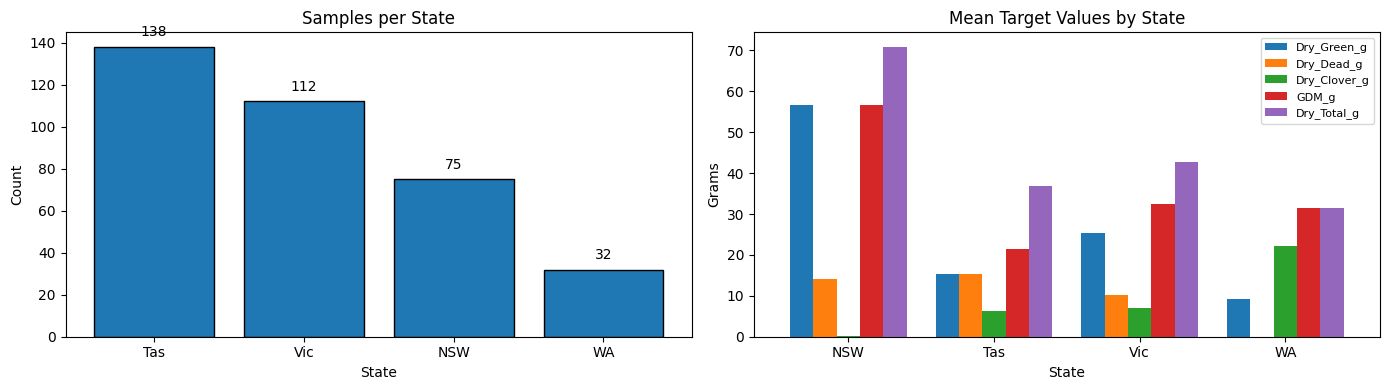

In [13]:
# State distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

state_counts = df_wide['State'].value_counts()
axes[0].bar(state_counts.index, state_counts.values, edgecolor='black')
axes[0].set_title('Samples per State')
axes[0].set_xlabel('State')
axes[0].set_ylabel('Count')
for i, v in enumerate(state_counts.values):
    axes[0].text(i, v + 5, str(v), ha='center')

# Target means by state
state_means = df_wide.groupby('State')[targets].mean()
state_means.plot(kind='bar', ax=axes[1], width=0.8)
axes[1].set_title('Mean Target Values by State')
axes[1].set_ylabel('Grams')
axes[1].legend(loc='upper right', fontsize=8)
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

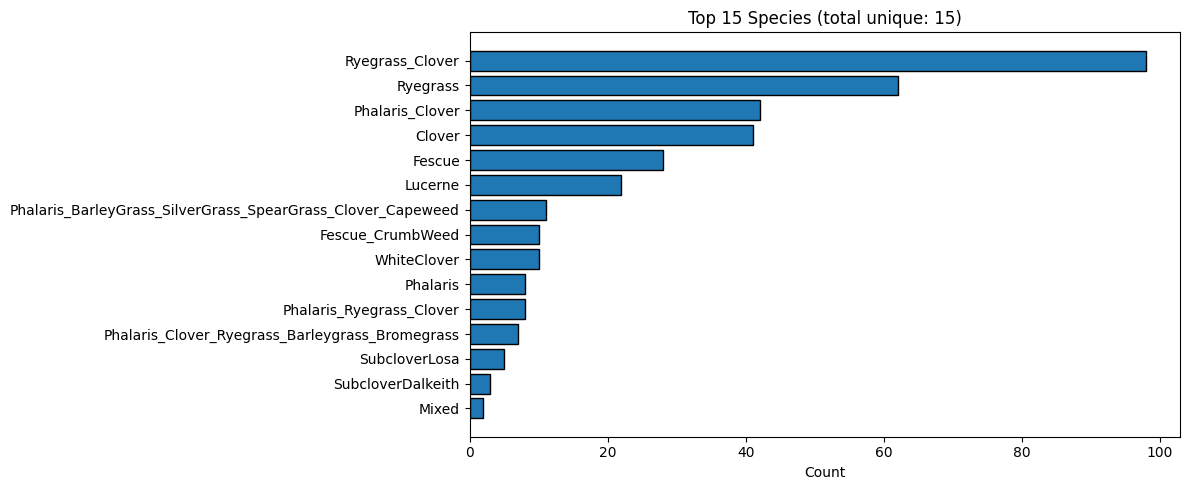

In [14]:
# Top species
species_counts = df_wide['Species'].value_counts().head(15)
plt.figure(figsize=(12, 5))
plt.barh(species_counts.index[::-1], species_counts.values[::-1], edgecolor='black')
plt.xlabel('Count')
plt.title(f'Top 15 Species (total unique: {df_wide["Species"].nunique()})')
plt.tight_layout()
plt.show()

In [15]:
# Clover presence and Dry_Clover_g relationship
df_wide['has_clover'] = df_wide['Species'].str.lower().str.contains('clover')
clover_stats = df_wide.groupby('has_clover')['Dry_Clover_g'].agg(['mean', 'median', 'count', lambda x: (x > 0).sum()])
clover_stats.columns = ['mean', 'median', 'count', 'non_zero']
clover_stats['non_zero_pct'] = 100 * clover_stats['non_zero'] / clover_stats['count']
print("Dry_Clover_g by species containing 'clover':")
print(clover_stats)

Dry_Clover_g by species containing 'clover':
                 mean  median  count  non_zero  non_zero_pct
has_clover                                                  
False        0.328836  0.0000    132        24     18.181818
True        10.357928  5.0001    225       198     88.000000


## 6. Temporal Analysis

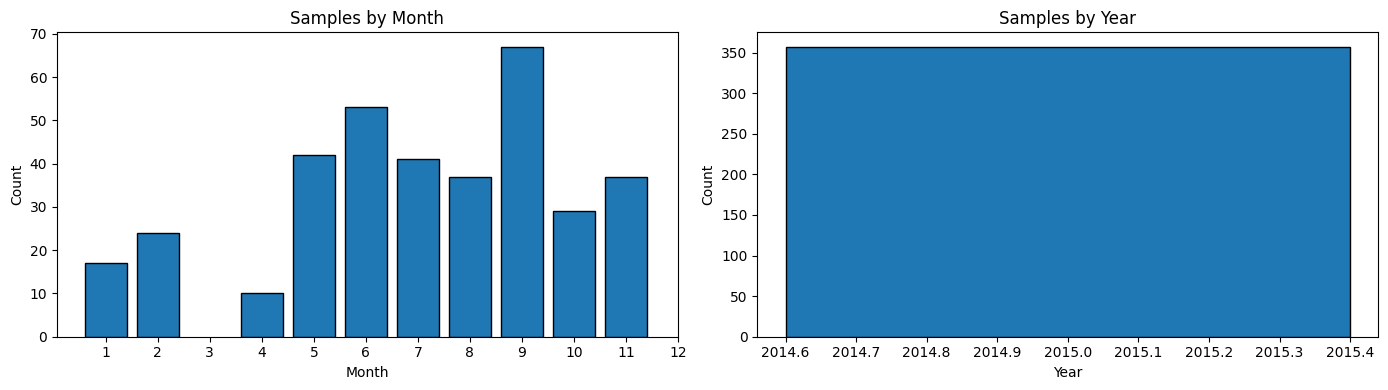

In [16]:
# Parse dates
df_wide['date'] = pd.to_datetime(df_wide['Sampling_Date'])
df_wide['month'] = df_wide['date'].dt.month
df_wide['year'] = df_wide['date'].dt.year

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Samples by month
month_counts = df_wide['month'].value_counts().sort_index()
axes[0].bar(month_counts.index, month_counts.values, edgecolor='black')
axes[0].set_title('Samples by Month')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Count')
axes[0].set_xticks(range(1, 13))

# Samples by year
year_counts = df_wide['year'].value_counts().sort_index()
axes[1].bar(year_counts.index, year_counts.values, edgecolor='black')
axes[1].set_title('Samples by Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

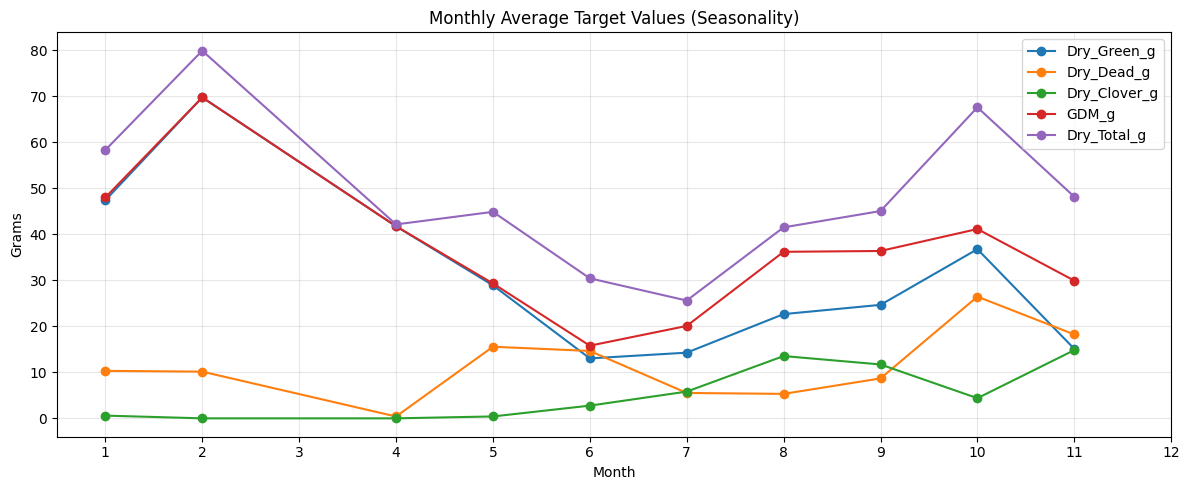

In [17]:
# Seasonal patterns in targets
monthly_means = df_wide.groupby('month')[targets].mean()
monthly_means.plot(figsize=(12, 5), marker='o')
plt.title('Monthly Average Target Values (Seasonality)')
plt.xlabel('Month')
plt.ylabel('Grams')
plt.xticks(range(1, 13))
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Sample Images - Highest Target Per Class

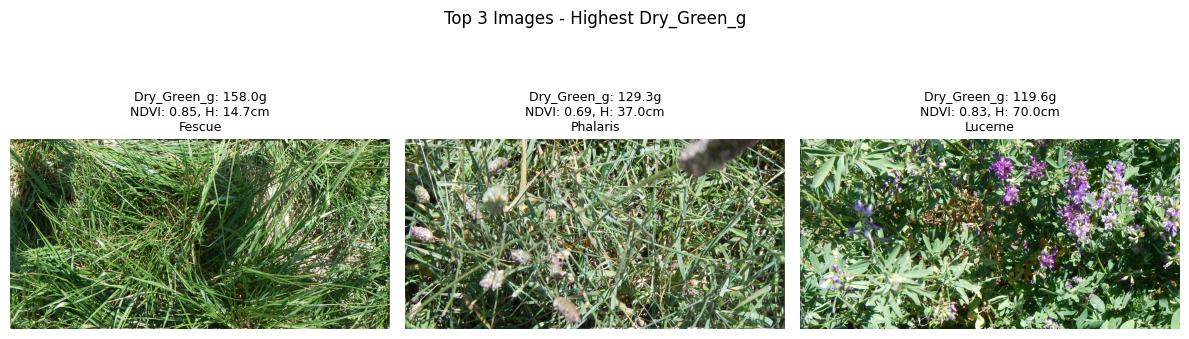

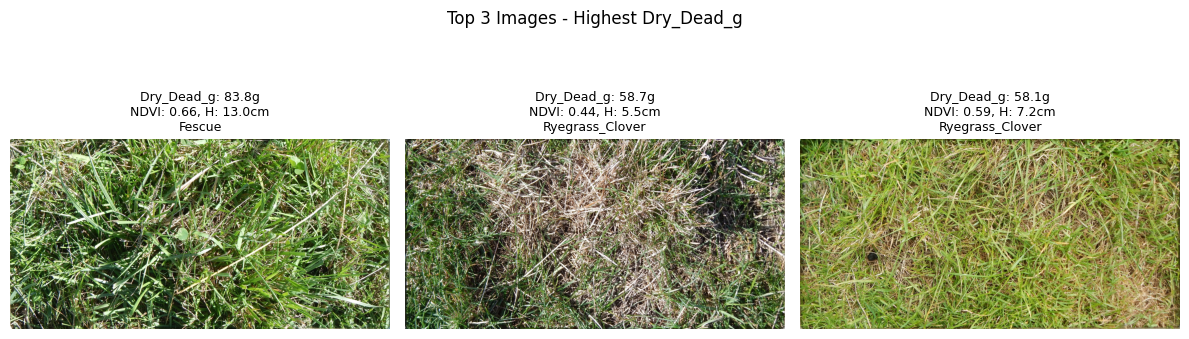

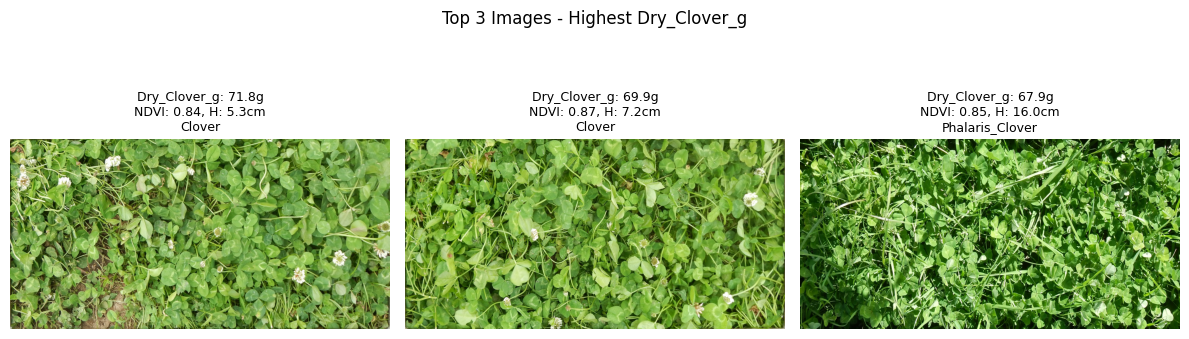

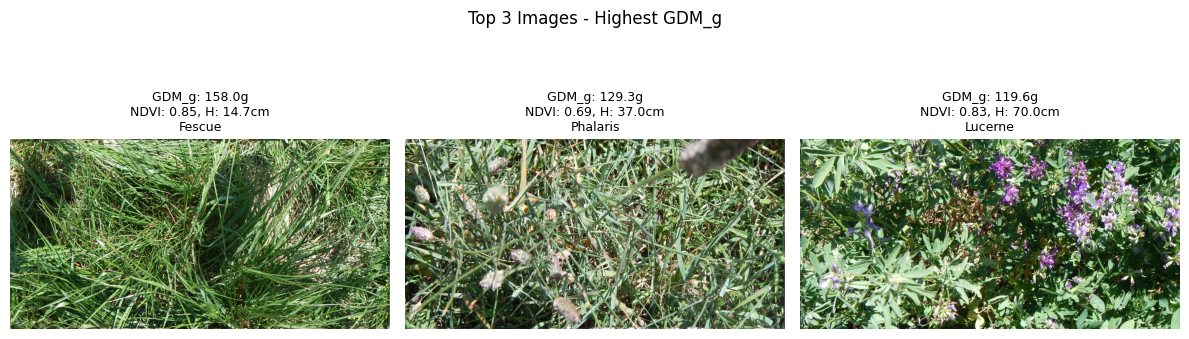

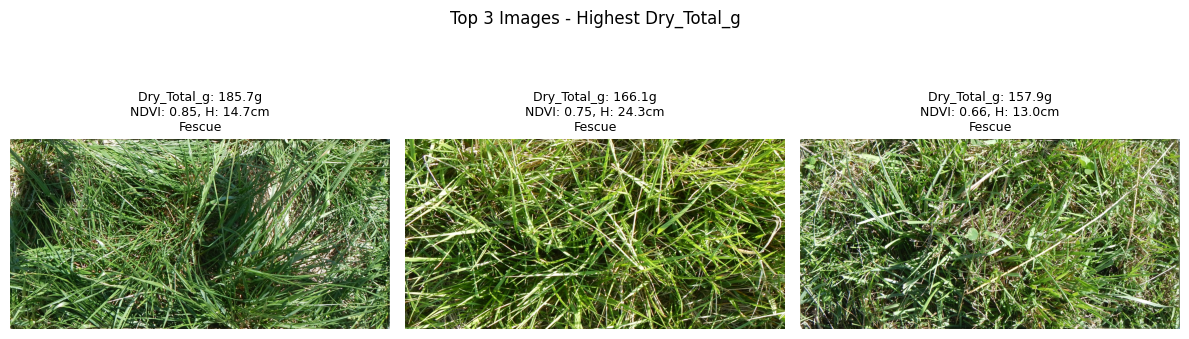

In [18]:
def show_top_images(target, n=3):
    """Display top n images with highest values for a target"""
    top_samples = df_wide.nlargest(n, target)
    
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    if n == 1:
        axes = [axes]
    
    for i, (_, row) in enumerate(top_samples.iterrows()):
        img_path = DATA_DIR / row['image_path']
        if img_path.exists():
            img = Image.open(img_path)
            axes[i].imshow(img)
            title = f"{target}: {row[target]:.1f}g\n"
            title += f"NDVI: {row['Pre_GSHH_NDVI']:.2f}, H: {row['Height_Ave_cm']:.1f}cm\n"
            title += f"{row['Species'][:25]}"
            axes[i].set_title(title, fontsize=9)
        else:
            axes[i].text(0.5, 0.5, 'Image not found', ha='center', va='center')
        axes[i].axis('off')
    
    plt.suptitle(f'Top {n} Images - Highest {target}', fontsize=12, y=1.02)
    plt.tight_layout()
    plt.show()

for target in targets:
    show_top_images(target, n=3)

## 8. Image Properties

In [19]:
# Check image sizes (sample a few)
sample_images = df_wide['image_path'].head(10).tolist()
sizes = []
for img_path in sample_images:
    full_path = DATA_DIR / img_path
    if full_path.exists():
        img = Image.open(full_path)
        sizes.append(img.size)

print("Sample image sizes (W x H):")
for s in set(sizes):
    print(f"  {s[0]} x {s[1]} - count: {sizes.count(s)}")

Sample image sizes (W x H):
  2000 x 1000 - count: 10


## 9. Key Insights for SOTA Model

In [20]:
print("""
=== KEY INSIGHTS FOR SOTA BIOMASS PREDICTION ===

1. TARGET STRUCTURE:
   - 5 targets, but only 3 are independent: Dry_Green_g, Dry_Dead_g, Dry_Clover_g
   - Dry_Total_g = Green + Dead + Clover
   - GDM_g = Green + Clover
   -> Consider multi-task learning for the 3 base targets

2. DATA CHARACTERISTICS:
   - Heavy zero-inflation, especially Dry_Clover_g (many zeros)
   - Right-skewed distributions -> use log1p(target) for training
   - Strong correlations between targets -> shared representations help

3. FEATURE IMPORTANCE:
   - NDVI correlates positively with green biomass (r~0.2-0.4)
   - Height correlates strongly with total/green biomass (r~0.4-0.5)
   - Species is highly predictive (especially for clover presence)
   -> Include metadata as auxiliary inputs

4. DATA SPLITS:
   - Consider stratifying by State or Species for robust CV
   - Temporal leakage: samples from same date/location may be similar

5. ARCHITECTURE RECOMMENDATIONS:
   - Image backbone: EfficientNet-V2, ConvNeXt, or ViT
   - Multi-task head: 3 outputs (Green, Dead, Clover) + derive Total/GDM
   - Auxiliary inputs: Concatenate NDVI, Height, State embedding, Species embedding
   - Loss: MSE on log1p(targets) or Huber loss for robustness

6. AUGMENTATIONS:
   - Standard: RandomCrop, HorizontalFlip, ColorJitter
   - Domain-specific: Consider rotation (pastures have no orientation bias)
   - Careful with: Heavy color augmentation (affects green/dead distinction)

7. HANDLING ZEROS:
   - Option A: Two-stage model (classification + regression)
   - Option B: Zero-inflated loss function
   - Option C: Treat as regression with log1p (simpler, often works)
""")


=== KEY INSIGHTS FOR SOTA BIOMASS PREDICTION ===

1. TARGET STRUCTURE:
   - 5 targets, but only 3 are independent: Dry_Green_g, Dry_Dead_g, Dry_Clover_g
   - Dry_Total_g = Green + Dead + Clover
   - GDM_g = Green + Clover
   -> Consider multi-task learning for the 3 base targets

2. DATA CHARACTERISTICS:
   - Heavy zero-inflation, especially Dry_Clover_g (many zeros)
   - Right-skewed distributions -> use log1p(target) for training
   - Strong correlations between targets -> shared representations help

3. FEATURE IMPORTANCE:
   - NDVI correlates positively with green biomass (r~0.2-0.4)
   - Height correlates strongly with total/green biomass (r~0.4-0.5)
   - Species is highly predictive (especially for clover presence)
   -> Include metadata as auxiliary inputs

4. DATA SPLITS:
   - Consider stratifying by State or Species for robust CV
   - Temporal leakage: samples from same date/location may be similar

5. ARCHITECTURE RECOMMENDATIONS:
   - Image backbone: EfficientNet-V2, ConvNe

In [21]:
# Summary statistics for reference
print("\n=== QUICK REFERENCE STATS ===")
print(f"\nTotal images: {n_images}")
print(f"States: {list(df_wide['State'].unique())}")
print(f"Species: {df_wide['Species'].nunique()} unique")
print(f"\nNDVI range: {df_wide['Pre_GSHH_NDVI'].min():.2f} - {df_wide['Pre_GSHH_NDVI'].max():.2f}")
print(f"Height range: {df_wide['Height_Ave_cm'].min():.1f} - {df_wide['Height_Ave_cm'].max():.1f} cm")
print(f"\nTarget ranges (grams):")
for t in targets:
    print(f"  {t}: {df_wide[t].min():.1f} - {df_wide[t].max():.1f} (median: {df_wide[t].median():.1f})")


=== QUICK REFERENCE STATS ===

Total images: 357
States: ['Tas', 'NSW', 'WA', 'Vic']
Species: 15 unique

NDVI range: 0.16 - 0.91
Height range: 1.0 - 70.0 cm

Target ranges (grams):
  Dry_Green_g: 0.0 - 158.0 (median: 20.8)
  Dry_Dead_g: 0.0 - 83.8 (median: 8.0)
  Dry_Clover_g: 0.0 - 71.8 (median: 1.4)
  GDM_g: 1.0 - 158.0 (median: 27.1)
  Dry_Total_g: 1.0 - 185.7 (median: 40.3)
